In [6]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, einsum
from torchvision import transforms
import matplotlib.pyplot as plt
import math
from inspect import isfunction
from functools import partial
from tqdm import tqdm, trange
from einops import rearrange

import sys, os
sys.path.append("../") # important for relative imports to work

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from utils.datamodule import CIFAR10Datamodule, MNISTDatamodule, AnimeDataModule
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

train_dm = AnimeDataModule("data/anime_faces",batch_size=32, train = True)
val_dm = AnimeDataModule("data/anime_faces",batch_size=32, train = False)

Typical image shape: (3, 64, 64)


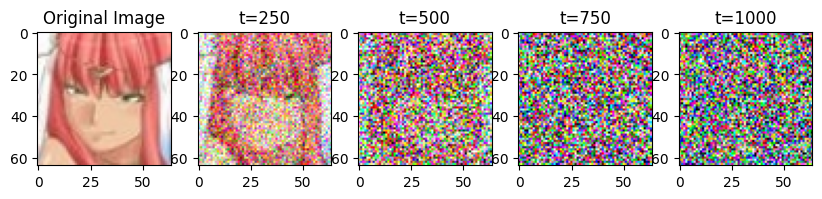

In [9]:
from train.beta_schedules import *
import numpy as np
from utils.tools import get_arrs, timestep_to_tensor, show_tensor
from train.diffusion_process import forward_diffuse

FORWARD_STEPS = 1000
scheduler_dict = get_arrs(quadratic_beta_schedule, device, forward_steps=FORWARD_STEPS)

_, HEIGHT, WIDTH, CHANNELS = next(iter(train_dm.dataloader))[0].shape
print("Typical image shape:", (HEIGHT, WIDTH, CHANNELS))

fig, ax = plt.subplots(1, 5, figsize=(10, 5))
im = next(iter(train_dm.dataloader))[0][:1].to(device)

ax[0].imshow(show_tensor(im[0]))
ax[0].set_title("Original Image")
for i in range(1, 5):
    im, _ = forward_diffuse(im, timestep_to_tensor(i*(FORWARD_STEPS//4) - 1, device), 
                            scheduler_dict, forward_steps=FORWARD_STEPS)
    ax[i].imshow(show_tensor(im[0]))
    ax[i].set_title(f"t={i*(FORWARD_STEPS//4)}")

In [10]:
from models.unet import KarrasUNet
import numpy as np

# From scratch
model = KarrasUNet(dim = 128, dim_mults = (1, 2, 4, 4, 8))

# Load model
# model = torch.load("../saved_models/ddpm_cifar10_quadratic_schedule_6_epochs.pth")

model = model.to(device)
# Multi GPU training
# model = nn.DataParallel(model, device_ids=[2, 3])
epsilon_theta = model(im, timestep_to_tensor(0, device = device))
assert epsilon_theta.shape == im.shape

In [15]:
# Main Training Loop
NUM_EPOCHS = 20

from train.diffusion_process import DDPM_denoising_step, DDPM_denoising_process
from train.vis_utils import visualize_DDPM_denoising

from torch import optim
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay = 0)

loss_ema = None
for epoch in range(NUM_EPOCHS):
    visualize_DDPM_denoising(scheduler_dict,
                               model,
                               shape = (HEIGHT, WIDTH, CHANNELS),
                               forward_steps = FORWARD_STEPS, steps_to_show = 5, rows_to_show = 2,
                               device = device)
    with tqdm(train_dm.dataloader) as pbar:
        for x, class_label in pbar:
            x = x.to(device); class_label = class_label.to(device)
            # TODO: Condition on class label
            t = torch.randint(0, FORWARD_STEPS, (x.shape[0],), device = device) # batch of t
            x_t, noise = forward_diffuse(x, t, scheduler_dict)
            epsilon_theta = model(x_t, t)
            # loss = F.mse_loss(epsilon_theta, noise) # TODO: Experiment with l1 loss
            # Huber loss:
            loss = F.smooth_l1_loss(epsilon_theta, noise)
            loss.backward()
            loss_ema = round(loss_ema * 0.95 + loss.item() * 0.05 if loss_ema else loss.item(), 3)
            optimizer.step()
            optimizer.zero_grad()
            pbar.set_postfix({"Training loss": loss_ema})

    validation_loss = []
    with torch.no_grad():
        with tqdm(val_dm.dataloader) as pbar:
            for x, class_label in pbar:
                x = x.to(device); class_label = class_label.to(device)
                t = torch.randint(0, FORWARD_STEPS, (x.shape[0],), device = device)
                x_t, noise = forward_diffuse(x, t, scheduler_dict)
                epsilon_theta = model(x_t, t)
                loss = F.smooth_l1_loss(epsilon_theta, noise)
                validation_loss.append(loss.item())
    mean_val_loss = sum(validation_loss) / len(validation_loss)
    print(f"Epoch {epoch}. Validation loss: {mean_val_loss:.3f}")
visualize_DDPM_denoising(scheduler_dict,
                               model,
                               shape = (HEIGHT, WIDTH, CHANNELS),
                               forward_steps = FORWARD_STEPS, steps_to_show = 5, rows_to_show = 2,
                               device = device)

  2%|▏         | 24/1000 [00:00<00:17, 55.61it/s]

In [ ]:
# Visualize
ims = visualize_DDPM_denoising(scheduler_dict,
                               model,
                               shape = (HEIGHT, WIDTH, CHANNELS),
                               forward_steps = FORWARD_STEPS, steps_to_show = 5, rows_to_show = 3,
                               device = device)

In [18]:
# Save model
torch.save(model, "../saved_models/ddpm_cifar10_quadratic_schedule_6_epochs.pth")